In [1]:
import geopandas as gpd
import pandas as pd
import sqlite3
import rasterio
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import rasterio
from rasterio.mask import mask
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

In [2]:
#Q1
df = gpd.read_file("counties.geojson")
len(df)

72

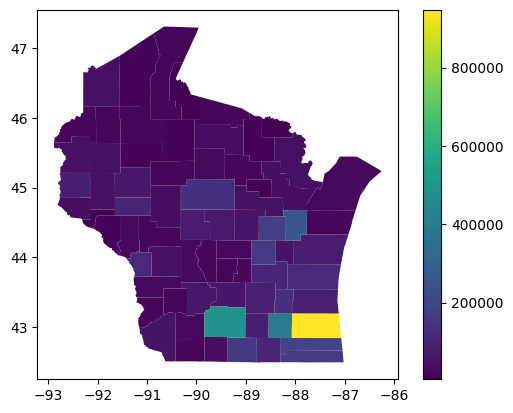

In [3]:
#Q2
ax = df.plot(column = 'POP100', legend = True)

In [4]:
conn = sqlite3.connect("counties_tracts.db")
pd.read_sql("""SELECT * FROM sqlite_master""", conn)

,type,name,tbl_name,rootpage,sql
0,table,counties,counties,2,"CREATE TABLE ""counties"" (\n""index"" INTEGER,\n ..."
1,index,ix_counties_index,counties,3,"CREATE INDEX ""ix_counties_index""ON ""counties"" ..."
2,table,tracts,tracts,4,"CREATE TABLE ""tracts"" (\n""index"" INTEGER,\n ""..."
3,index,ix_tracts_index,tracts,5,"CREATE INDEX ""ix_tracts_index""ON ""tracts"" (""in..."


In [5]:
AREALAND = pd.read_sql("""SELECT AREALAND FROM counties""", conn)
df["AREALAND"] = AREALAND

In [6]:
train, test = train_test_split(df, random_state=250, test_size=0.25)

In [7]:
#Q3
conn = sqlite3.connect("counties_tracts.db")
df['AREALAND'] = pd.read_sql("SELECT * FROM counties", conn)['AREALAND']
train, test = train_test_split(df, random_state = 320, test_size = 0.25)

list(test['NAME'])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [8]:
#Q4
model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
model.score(test[["AREALAND"]], test["POP100"])

0.022002661530554857

In [9]:
#Q5
scaled_train = train[["AREALAND"]] / 2590000
model = LinearRegression()
model.fit(scaled_train, train["POP100"])
predict_df = pd.DataFrame({"AREALAND": [300 * 2590000]})
scaled_predict_df = predict_df / 2590000
predicted_population = model.predict(scaled_predict_df)[0]
predicted_population_value = float(predicted_population)
predicted_population_value

89016.40396725971

In [10]:
#Q6
hu100_df = pd.read_sql("""
SELECT counties.NAME, sum(HU100) as HU100
FROM tracts
INNER JOIN counties ON tracts.COUNTY = counties.COUNTY
GROUP BY counties.NAME
""", conn)

df = pd.merge(df, hu100_df, how = 'inner', on = 'NAME')
train, test = train_test_split(df, random_state = 320, test_size = 0.25)

list(test['NAME'])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [11]:
#Q7
dict(zip(test.NAME, test.HU100))

{'Kewaunee County': 9304,
 'Calumet County': 19695,
 'Adams County': 17436,
 'Eau Claire County': 42151,
 'Milwaukee County': 418053,
 'Ashland County': 9656,
 'Wood County': 34088,
 'Dodge County': 37005,
 'Sauk County': 29708,
 'Clark County': 15076,
 'Pepin County': 3579,
 'Taylor County': 10582,
 'Iron County': 5999,
 'Outagamie County': 73149,
 'Florence County': 4780,
 'Oneida County': 30125,
 'Pierce County': 16132,
 'Grant County': 21581}

In [12]:
#Q8
scores = cross_val_score(model, train[["HU100"]], train["POP100"])
x = float(scores.mean())
x

0.9652534544116037

In [13]:
#Q9
scores.std()
x = float(scores.std())
x

0.03704265206670459

In [14]:
#Q10
model.fit(train[['HU100']], train['POP100'])
coef = round(model.coef_[0], 2)
intercept = round(model.intercept_, 2)
f"POP100 = {coef}*HU100 + {intercept}"

'POP100 = 2.39*HU100 + -7910.46'

In [15]:
#Q11
model = LinearRegression()
model.fit(train[['HU100']], train['POP100'])
test_predictions = model.predict(test[['HU100']])
r_squared = r2_score(test['POP100'], test_predictions)

r_squared

0.9958323488562859

Text(7    160864
Name: HU100, dtype: int64, 7    389891
Name: POP100, dtype: int64, 'Waukesha')

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y)

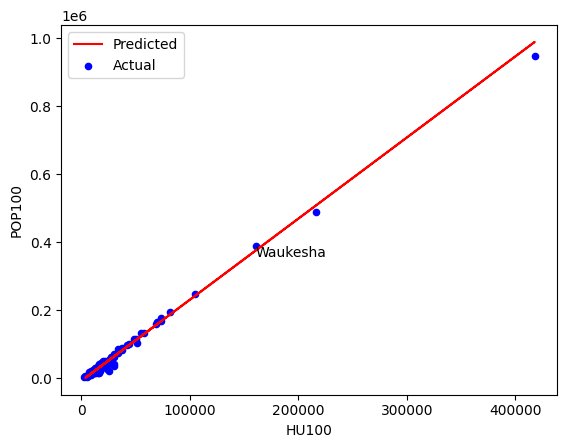

In [16]:
#Q12
model = LinearRegression()
xcols = ["HU100"]
ycol = "POP100"

model.fit(train[xcols], train[ycol])
test["Predicted"] = model.predict(test[['HU100']])
ax = test.plot.line(x="HU100", y="Predicted", color="r")
actual = df.plot.scatter(x="HU100", y="POP100", ax=ax, color="b", label = "Actual")
x = df[df['NAME'] == 'Waukesha County']["HU100"]
y = df[df['NAME'] == 'Waukesha County']["POP100"]
actual.text(x,y,'Waukesha',  ha="left", va="top")

In [17]:
#Q13
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

x = int(((4>= A)*(A>=1)).astype(int).sum())
x

13

In [18]:
from matplotlib.colors import ListedColormap

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

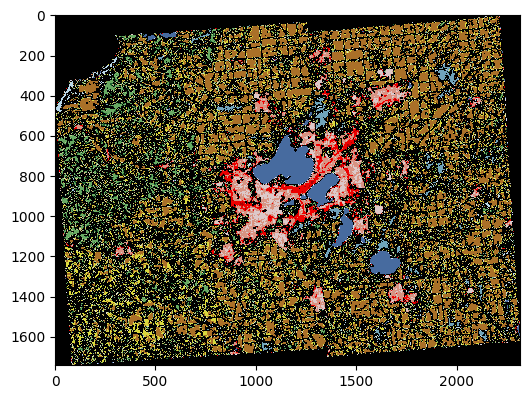

In [19]:
#Q14
land = rasterio.open("zip://./land.zip!/wi.tif")
dane = gpd.GeoDataFrame(df.set_index("NAME")['geometry'].loc[["Dane County"]])

matrix, _ = mask(land, dane.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(matrix, vmin=0, vmax=255, cmap = custom_cmap)

In [20]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

In [21]:
#Q15
dane_total = (matrix != 0).astype(int).sum()
dane_water = (matrix == land_use['crops']).astype(int).sum()
x = float(dane_water / dane_total)
x

0.46705544316564085

<Axes: xlabel='EVERGREEN', ylabel='POP100'>

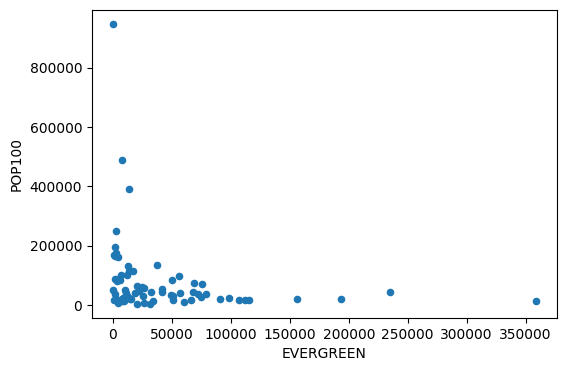

In [22]:
#Q16
counties_gdf = gpd.read_file('counties.geojson')
land = rasterio.open("zip://./land.zip!/wi.tif")

evergreen_list = []

for county in counties_gdf["NAME"]:
    df = counties_gdf[counties_gdf["NAME"] == county]
    matrix, _ = mask(land, df.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]  
    evergreen = sum(sum(matrix==42))
    evergreen_list.append(evergreen)
    
counties_gdf["EVERGREEN"] = evergreen_list
fig, ax = plt.subplots(figsize=(6,4))
counties_gdf.plot.scatter(ax=ax, x='EVERGREEN', y='POP100')

In [23]:
file = "tracts.shp"
tracts_df = gpd.read_file(file)
tracts_df

,GEOID,POP100,geometry
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02627 44.089..."
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.15010 44.513..."
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53547 44.334..."
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.89338 44.678..."
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.05841 44.461..."
...,...,...,...
1537,55139003100,2046,"POLYGON ((-88.47454 44.19198, -88.47450 44.192..."
1538,55079017900,2879,"POLYGON ((-87.91064 42.99520, -87.91038 42.995..."
1539,55059000800,2763,"POLYGON ((-87.84574 42.60276, -87.84548 42.602..."
1540,55025013700,7107,"POLYGON ((-89.57788 42.98135, -89.57788 42.981..."


In [24]:
feature_tract_list = []
for cty in tracts_df["GEOID"]:
    data = {}
    row = tracts_df[tracts_df["GEOID"] == f"{cty}"]
    matrix, _ = mask(land, row.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    for key in land_use:
        code = land_use[key]
        tract_ct = (matrix==code).astype(int).sum()
        data[key] = tract_ct
    feature_tract_list.append(data)
    
feature_tract = pd.DataFrame(feature_tract_list)

In [25]:
tracts_df = pd.concat([tracts_df, feature_tract], axis=1, join='inner')

In [26]:
 train, test = train_test_split(tracts_df, random_state=320, test_size=0.25)

In [27]:
model = LinearRegression()
xcols = list(land_use.keys())
ycol = "POP100"

model.fit(train[xcols], train[ycol])
test["Predicted POP100"] = model.predict(test[xcols])
model.score(test[xcols], test[ycol])

0.448672854166578

<Axes: >

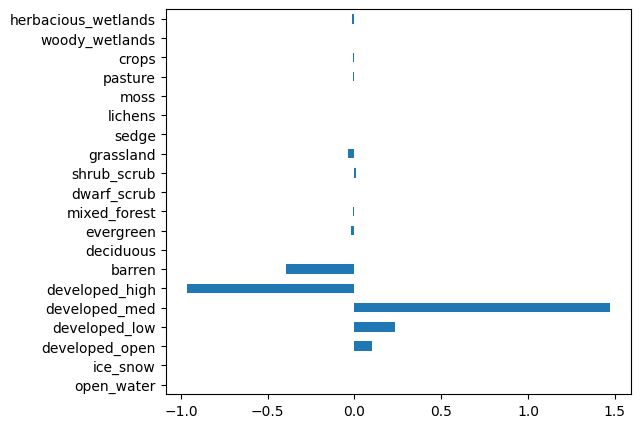

In [28]:
#Q17
pd.Series(model.coef_, index=xcols).plot.barh(figsize=(6,5))
# This chart illustrates the factors the model considers important for predicting population,
# highlighting which features it found most influential. 
# Essentially, it shows that in our model, land features have minimal impact on population prediction, 
# except for whether an area is developed. 
# Therefore, removing most of these features from the model would likely yield similar results.

In [29]:
#Q18

In [30]:
#Q19